# Part 2 - Modelling

---

Insert some background and recap of part 1 notebook.

In [1]:
import pandas as pd
import numpy as np
import re
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, get_scorer_names
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA

# imblearn for sampling
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# set random state for model results reproducibility
rng = 42

import warnings
warnings.filterwarnings('ignore') # hide warnings to avoid cluttering the notebook output

In [2]:
class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None
        self._elapsed_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._elapsed_time = None
        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        self._elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {int(divmod(self._elapsed_time, 60)[0])} minutes, {int(divmod(self._elapsed_time, 60)[1])} seconds")

    def duration(self) -> float:
        """Return the elapsed time from the timer."""
        if self._elapsed_time is None:
            raise TimerError("Timer has not run. Use .start() and .stop() to start and stop the timer.")
        return self._elapsed_time

We prepare the train and validation data for modelling.

In [3]:
df = pd.read_csv('../assets/df_merge_final.csv', parse_dates=['Date', 'Sunrise_1', 'Sunset_1'])

In [4]:
df.head()

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station,Tavg,...,Heat,CodeSum,PrecipTotal,SeaLevel,ResultDir,AvgSpeed,Sunrise_1,Sunset_1,daylight_duration,Humidity
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,1,0,1.0,69.0,...,0.0,RA BR,0.38,29.84,27.0,12.3,1900-01-01 04:32:00,1900-01-01 19:04:00,0 days 14:32:00,63.27
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,9,1,0,1.0,69.0,...,0.0,RA BR,0.38,29.84,27.0,12.3,1900-01-01 04:32:00,1900-01-01 19:04:00,0 days 14:32:00,63.27
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,9,1,0,1.0,69.0,...,0.0,RA BR,0.38,29.84,27.0,12.3,1900-01-01 04:32:00,1900-01-01 19:04:00,0 days 14:32:00,63.27
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,8,1,0,1.0,69.0,...,0.0,RA BR,0.38,29.84,27.0,12.3,1900-01-01 04:32:00,1900-01-01 19:04:00,0 days 14:32:00,63.27
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,8,4,0,1.0,69.0,...,0.0,RA BR,0.38,29.84,27.0,12.3,1900-01-01 04:32:00,1900-01-01 19:04:00,0 days 14:32:00,63.27


In [5]:
def create_dt_features(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Perform feature engineering and return dataframe.
    '''
    # create datetime related features
    dataframe['daylight_duration'] = pd.to_timedelta(dataframe['daylight_duration'])
    dataframe['Daylight_hours'] = round(dataframe['daylight_duration'].dt.total_seconds() / (60*60), 2)
    dataframe['Sunrise'] = round(pd.to_timedelta(dataframe['Sunrise_1'].dt.time.astype(str)).dt.total_seconds()/3600, 2)
    dataframe['Sunset'] = round(pd.to_timedelta(dataframe['Sunset_1'].dt.time.astype(str)).dt.total_seconds()/3600, 2)
    # create date related features
    dataframe['Month'] = dataframe['Date'].dt.month
    dataframe['Day'] = dataframe['Date'].dt.day
    # round off Latitude, Longitude to generalise locations by area
    dataframe['Latitude'] = round(dataframe['Latitude'], 2)
    dataframe['Longitude'] = round(dataframe['Longitude'], 2)
    # group satellite traps
    dataframe['Trap'] = dataframe['Trap'].str.strip('TABC')
    # main vector species in USA (https://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health/)
    dataframe['Vector'] = np.where(dataframe['Species'].str.contains(r'(pipiens|tarsalis|quinquefasciatus)', case = False), 1, 0)

    return dataframe

In [6]:
df = create_dt_features(df)

In [7]:
# specify features
num_features = ['Latitude', 'Longitude', 'AddressAccuracy', 'Tavg', 'Depart', 'Heat', 'PrecipTotal', 'SeaLevel', 'ResultDir', 'AvgSpeed', 'Humidity', 'Daylight_hours', 'Sunrise', 'Sunset', 'Vector']
cat_features = ['Trap', 'Month']
# text_features = ['CodeSum']

features = num_features + cat_features # + text_features

In [8]:
df[features].head()

,Latitude,Longitude,AddressAccuracy,Tavg,Depart,Heat,PrecipTotal,SeaLevel,ResultDir,AvgSpeed,Humidity,Daylight_hours,Sunrise,Sunset,Vector,Trap,Month
0,41.95,-87.80,9,69.0,11.0,0.0,0.38,29.84,27.0,12.3,63.27,14.53,4.53,19.07,1,002,5
1,41.95,-87.80,9,69.0,11.0,0.0,0.38,29.84,27.0,12.3,63.27,14.53,4.53,19.07,0,002,5
2,41.99,-87.77,9,69.0,11.0,0.0,0.38,29.84,27.0,12.3,63.27,14.53,4.53,19.07,0,007,5
3,41.97,-87.82,8,69.0,11.0,0.0,0.38,29.84,27.0,12.3,63.27,14.53,4.53,19.07,1,015,5
4,41.97,-87.82,8,69.0,11.0,0.0,0.38,29.84,27.0,12.3,63.27,14.53,4.53,19.07,0,015,5


In [9]:
X = df[features]
y = df['WnvPresent']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, stratify=y)

## Modelling

---

We will utilise a mixture of methods for handling different types of features within our dataset, using a ColumnTransformer together with Pipelines.

In [11]:
# Processing steps before modelling (standardisation, one hot encoding, over/under-sampling)
minmax = MinMaxScaler(feature_range=(0, 1))
ohe = OneHotEncoder(drop='if_binary', handle_unknown='infrequent_if_exist')
count = CountVectorizer()

sample_smotetomek = SMOTETomek(random_state=rng, n_jobs=2)

pca = PCA()

# create pipeline for handling CodeSum feature
text_pipe = Pipeline([
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', count),
    ('array', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('scale', minmax)
])

col_transform = ColumnTransformer([
    # ('MinMaxScaler', minmax, num_features),
    ('OneHotEncoder', ohe, cat_features),
    # ('CountVectorizer', text_pipe, text_features)
], remainder = 'passthrough',
sparse_threshold = 0
)

In [12]:
# check for PCA value to optimise
X_train_sc = col_transform.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_sc)

total_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_variance[total_variance >= .95])
n_to_reach_95 = X_train_pca.shape[1] - n_over_95 + 1
print(f'Number features: {n_to_reach_95} Total Variance Explained: {total_variance[n_to_reach_95-1]}')

n_over_80 = len(total_variance[total_variance >= .80])
n_to_reach_80 = X_train_pca.shape[1] - n_over_80 + 1
print(f'Number features: {n_to_reach_80} Total Variance Explained: {total_variance[n_to_reach_80-1]}')

Number features: 4 Total Variance Explained: 0.9569368219050156
Number features: 3 Total Variance Explained: 0.930203643964358


In [13]:
# Instantiating models for classification
lr = LogisticRegression(solver='liblinear', random_state=rng)
knn = KNeighborsClassifier()
# rf = RandomForestClassifier(random_state=rng)
et = ExtraTreesClassifier(random_state=rng)
ada = AdaBoostClassifier(random_state=rng)
hgbc = HistGradientBoostingClassifier(random_state=rng)

In [14]:
class ResultsError(Exception):
    """A custom exception used to report errors in use of Results class"""

class Results:
    def __init__(self, scoring_metric: list[str]):
        self.__results_dict = {}
        self.__results_dict['model_names']= []
        self.__results_dict['model']= []
        
        self.__scoring_metric = scoring_metric
        if type(self.__scoring_metric) == list:
            for metric in self.__scoring_metric:
                if metric not in get_scorer_names():
                    raise ResultsError('scoring metric must be an available scorer from sklearn, use sklearn.metrics.get_scorer_names() to retrieve the names of all available scorers.')
            for i, metric in enumerate(self.__scoring_metric):
                self.__results_dict[f'mean_train_{self.__scoring_metric[i]}'] = []
                self.__results_dict[f'mean_test_{self.__scoring_metric[i]}'] = []
                self.__results_dict[f'{self.__scoring_metric[i]}_delta']= []
        else:
            raise TypeError('scoring_metric must be list of string')

        self.__results_dict['best_params'] = []
        self.__results_dict['runtime'] = []

    # run pipe, fit params and return best estimator
    def run_pipe(self, clf: object, pipe_params=None):
        '''
        Places classifier into a Pipeline, which is then run in a GridSearchCV to optimise the model based on parameters passed. 

        Parameters
        ----------
        clf : object
            Classifier object
        pipe_params : dictionary
            Parameters to pass into GridSearchCV
            
        Returns
        -------
        Best Estimator
            Best estimator refitted from the GridSearchCV
        '''
        if not len(self.__results_dict):
            raise ResultsError('Error, no dictionary found. Use .create_results_dict() to create a dictionary first.')

        t = Timer()
        model_name = re.match(r'^(\w+)(?=\()', str(clf)).group()
        print(f"Fitting {model_name}")

        # create pipe
        pipe = Pipeline([
            ('transform', col_transform),
            ('scale', minmax),
            # ('pca', PCA(n_components=n_to_reach_95)),
            ('sample', sample_smotetomek),
            ('clf', clf)
        ])

        default_params = {
            # 'pca__n_components': [n_to_reach_95, n_to_reach_80],
        }
        
        # create GridSearchCV
        grid = GridSearchCV(
            estimator = pipe,
            param_grid = default_params | pipe_params,
            scoring = self.__scoring_metric,
            n_jobs = -3,
            cv = 3,
            verbose = 1,
            error_score = 0,
            refit = self.__scoring_metric[0],
        )

        t.start()
        grid.fit(X_train, y_train)
        t.stop()
        
        self._train_preds = grid.best_estimator_.predict(X_train)
        self._test_preds = grid.best_estimator_.predict(X_test)
      
        # store GridSearch scores
        self.__results_dict['model_names'].append(model_name)
        self.__results_dict['model'].append(grid.best_estimator_)

        for i, metric in enumerate(self.__scoring_metric):
            self.__results_dict[f'mean_train_{self.__scoring_metric[i]}'].append(roc_auc_score(y_train, self._train_preds))
            self.__results_dict[f'mean_test_{self.__scoring_metric[i]}'].append(roc_auc_score(y_test, self._test_preds))
            self.__results_dict[f'{self.__scoring_metric[i]}_delta'].append(
                abs(roc_auc_score(y_train, self._train_preds) - roc_auc_score(y_test, self._test_preds))
                )

        self.__results_dict['best_params'].append(grid.best_params_)
        self.__results_dict['runtime'].append(t.duration())

        print("Best Score: ", grid.best_score_)
        print("Best Params: ", grid.best_params_)
        print()
        return grid.best_estimator_

    def display(self) -> pd.DataFrame:
        '''Display pandas DataFrame displaying model performance results'''
        if not len(self.__results_dict):
            raise ResultsError('No results found. Use .run_pipe() to run pipe and store results.')
        model_df = pd.DataFrame(self.__results_dict)
        
        model_df.iloc[:, :-2] = model_df.iloc[:, :-2].round(4)
        model_df.iloc[:, -1] = model_df.iloc[:, -1].round(2)

        return model_df.sort_values(by=f"mean_test_{self.__scoring_metric[0]}", ascending=False)

In [15]:
# define scoring metrics for optimisation with GridSearchCV
score_metric = ['roc_auc']

results = Results(score_metric)

Create a set of parameters for each model to be passed into GridSearchCV for hyperparameter tuning.

In [16]:
lr_params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [100, 10, 1.0, 0.1, 0.01],
    'clf__max_iter': [200, 400],
    'clf__class_weight': ['balanced', None],
}

knn_params = {
    'clf__n_neighbors': [3, 5, 9, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]
}

et_params = {
    # 'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [10, 25, 50],
    # 'clf__class_weight': ['balanced', None],
    'clf__min_samples_leaf': [1, 5, 15]
}

ada_params = {
    'clf__learning_rate': [1.0, 2.0, 10],
    'clf__n_estimators': [50, 80, 120],
}

hgbc_params = {
    'clf__learning_rate': [0.001, 0.01, 0.1],
    'clf__l2_regularization': [0, 0.1, 1],
    'clf__max_iter': [80, 100, 120],
}

In [17]:
lr_best = results.run_pipe(lr, lr_params)

Fitting LogisticRegression
Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [ ]:
knn_best = results.run_pipe(knn, knn_params)

Fitting KNeighborsClassifier
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Elapsed time: 0 minutes, 29 seconds
Best Score:  0.7622305559707675
Best Params:  {'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'uniform'}



In [ ]:
# extremely overfitting
# et_best = results.run_pipe(et, et_params)

In [ ]:
ada_best = results.run_pipe(ada, ada_params)

Fitting AdaBoostClassifier
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Elapsed time: 0 minutes, 28 seconds
Best Score:  0.8228460372531211
Best Params:  {'clf__learning_rate': 1.0, 'clf__n_estimators': 120}



In [ ]:
hgbc_best = results.run_pipe(hgbc, hgbc_params)

Fitting HistGradientBoostingClassifier
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Elapsed time: 1 minutes, 8 seconds
Best Score:  0.8279244477553273
Best Params:  {'clf__l2_regularization': 0.1, 'clf__learning_rate': 0.1, 'clf__max_iter': 80}



In [ ]:
results.display()

,model_names,model,mean_train_roc_auc,mean_test_roc_auc,roc_auc_delta,best_params,runtime
0,LogisticRegression,"(ColumnTransformer(remainder='passthrough', sp...",0.7621,0.6792,0.0828,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",334.34
2,AdaBoostClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.7592,0.6762,0.0830,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",28.01
1,KNeighborsClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.8527,0.6511,0.2016,"{'clf__n_neighbors': 15, 'clf__p': 1, 'clf__we...",29.70
3,HistGradientBoostingClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.7990,0.6138,0.1851,"{'clf__l2_regularization': 0.1, 'clf__learning...",68.37


Based on the model_performance table, we see that the the `HistGradientBoostingClassifier` and `AdaBoostClassifier` appear to be performing the best. To optimise our predictions, we will utilise an ensemble method and use the two classifiers with a `VotingClassifier` as our final estimator.

<AxesSubplot:xlabel='model_names', ylabel='model_names'>

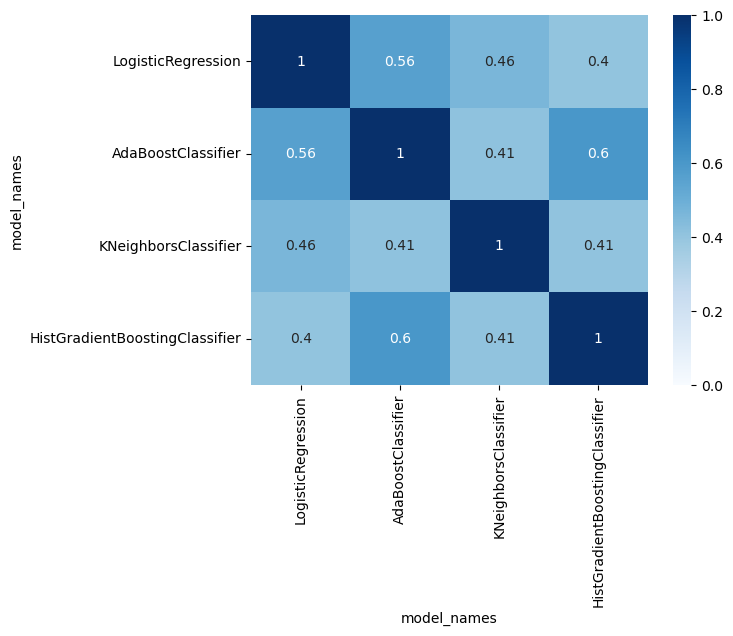

In [ ]:
# check correlation between our model predictions

predictions = []
for model in results.display()['model']:
    predictions.append(model.predict(X_train))

sns.heatmap(
    data = pd.DataFrame(
    np.column_stack(tuple(predictions)),
    columns = results.display()['model_names']
    ).corr(),
    annot = True,
    cmap = 'Blues',
    vmin = 0,
    vmax = 1
)

In [ ]:
# check coefficents from LogisticRegression
feature_names = lr_best[0].get_feature_names_out()
coefficients = lr_best[-1].coef_
features_coefs = pd.DataFrame([feature_names, coefficients.reshape(len(coefficients[0]),)]).transpose()
features_coefs.rename(columns={0: 'feature', 1: 'coef'}, inplace=True)
features_coefs.sort_values(by='coef', ascending=False).iloc[:50]

,feature,coef
143,remainder__Tavg,3.731779
137,OneHotEncoder__Month_8,1.656128
122,OneHotEncoder__Trap_228,1.575104
2,OneHotEncoder__Trap_003,1.521348
128,OneHotEncoder__Trap_235,1.465175
41,OneHotEncoder__Trap_061,1.39086
119,OneHotEncoder__Trap_225,1.353572
115,OneHotEncoder__Trap_221,1.353336
125,OneHotEncoder__Trap_231,1.309968
20,OneHotEncoder__Trap_028,1.117159


In [ ]:
# create VotingClassifier ensemble with top performing classifiers and new params
# voting_clf = VotingClassifier([
#     ('GradientBoost', GradientBoostingClassifier(n_estimators=300, random_state=rng)),
#     ('AdaBoost', AdaBoostClassifier(n_estimators=200, random_state=rng)),
#     ('RandomForest', RandomForestClassifier(n_estimators=700, max_features='sqrt', random_state=rng))
# ], voting='soft')

# voting_params = {
#     'sample__sampling_strategy': ['auto', 0.1, 0.3],
#     'clf__GradientBoost__learning_rate': [0.01, 0.1],
#     'clf__GradientBoost__subsample': [0.7, 1.0],
#     'clf__GradientBoost__max_depth': [3, 7],
#     'clf__AdaBoost__learning_rate': [1.0, 2.0, 10],
#     'clf__LogReg__solver': ['liblinear'],
#     'clf__LogReg__C': [100, 10, 1.0],
# }

In [ ]:
# create VotingClassifier ensemble with best performing classifiers
voting_clf = VotingClassifier([
    # ('HistGradientBoost', hgbc_best[-1]),
    ('AdaBoost', ada_best[-1]),
    ('LogReg', lr_best[-1]),
    # ('ExtraTrees', et_best[-1]),
    # ('Kneighbors', knn_best[-1])
], voting='soft')

voting_params = {
    'sample__sampling_strategy': ['auto', 0.1, 0.25, 0.5],
#     'clf__GradientBoost__learning_rate': [0.01, 0.1],
#     'clf__GradientBoost__subsample': [0.7, 1.0],
#     'clf__GradientBoost__max_depth': [3, 7],
#     'clf__AdaBoost__learning_rate': [1.0, 2.0, 10],
#     'clf__LogReg__solver': ['liblinear'],
#     'clf__LogReg__C': [100, 10, 1.0],
}

In [ ]:
voting_best = results.run_pipe(voting_clf, voting_params)

Fitting VotingClassifier
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Elapsed time: 0 minutes, 21 seconds
Best Score:  0.7996942701399038
Best Params:  {'sample__sampling_strategy': 'auto'}



In [ ]:
results.display()

,model_names,model,mean_train_roc_auc,mean_test_roc_auc,roc_auc_delta,best_params,runtime
5,VotingClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.7635,0.6800,0.0835,{'sample__sampling_strategy': 'auto'},21.16
0,LogisticRegression,"(ColumnTransformer(remainder='passthrough', sp...",0.7621,0.6792,0.0828,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",334.34
2,AdaBoostClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.7592,0.6762,0.0830,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",28.01
1,KNeighborsClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.8527,0.6511,0.2016,"{'clf__n_neighbors': 15, 'clf__p': 1, 'clf__we...",29.70
3,HistGradientBoostingClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.7990,0.6138,0.1851,"{'clf__l2_regularization': 0.1, 'clf__learning...",68.37
4,VotingClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.7791,0.5876,0.1915,{'sample__sampling_strategy': 0.25},24.62


Selecting the top performing model based on `balanced accuracy` score.

In [ ]:
best_model = voting_best

## Model Performance

---

Random text

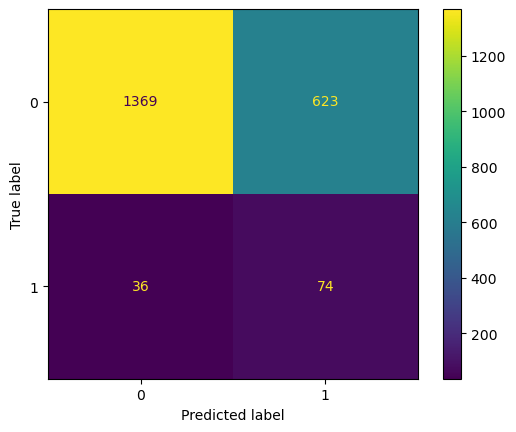

In [ ]:
preds = best_model.predict(X_test)
cm_disp = ConfusionMatrixDisplay.from_predictions(y_test, preds)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.69      0.81      1992
           1       0.11      0.67      0.18       110

    accuracy                           0.69      2102
   macro avg       0.54      0.68      0.49      2102
weighted avg       0.93      0.69      0.77      2102



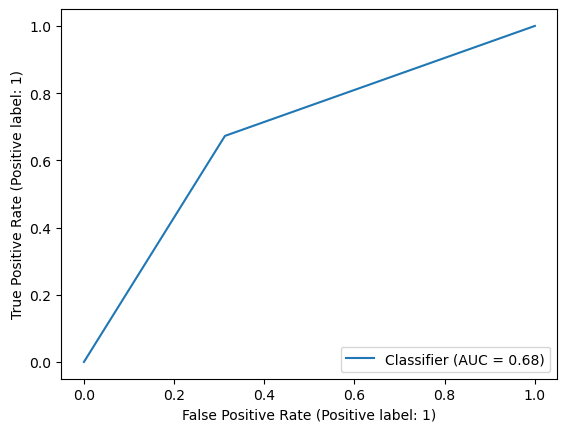

In [ ]:
RocCurveDisplay.from_predictions(y_test, preds)

In [ ]:
threshold = []
roc_auc_score_ = []

for p in np.linspace(0,1,101):
  threshold.append(p)
  y_pred = (best_model.predict_proba(X_train)[:,1] >= p).astype(int)
  roc_auc_score_.append(roc_auc_score(y_train,y_pred))

threshold_max = threshold[np.argmax(roc_auc_score_)]

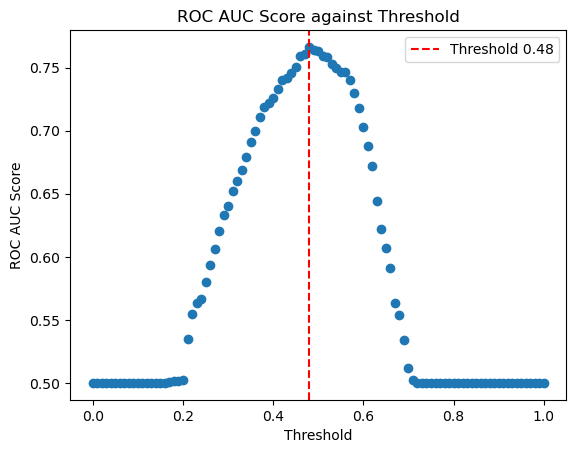

In [ ]:
plt.scatter(threshold,roc_auc_score_)
plt.axvline(x=threshold_max, linestyle='--', c='red', label=f'Threshold {threshold_max}')
plt.xlabel("Threshold")
plt.ylabel("ROC AUC Score")
plt.title("ROC AUC Score against Threshold")
plt.legend(loc='best')
plt.show();

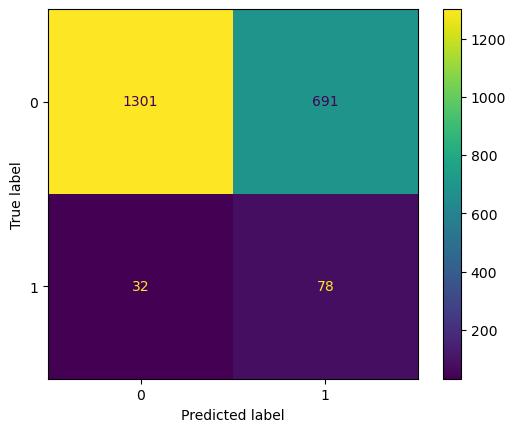

In [ ]:
y_hat = pd.Series(np.where(best_model.predict_proba(X_test)[:,1] >= threshold_max, 1, 0), 
                     dtype='category')
cm_disp_yhat = ConfusionMatrixDisplay.from_predictions(y_test, y_hat)

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1992
           1       0.10      0.71      0.18       110

    accuracy                           0.66      2102
   macro avg       0.54      0.68      0.48      2102
weighted avg       0.93      0.66      0.75      2102



In [ ]:
best_model.fit(X, y)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('OneHotEncoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['Trap', 'Month'])])),
                ('scale', MinMaxScaler()),
                ('sample', SMOTETomek(n_jobs=2, random_state=42)),
                ('clf',
                 VotingClassifier(estimators=[('AdaBoost',
                                               AdaBoostClassifier(n_estimators=120,
                                                                  random_state=42)),
                                              ('LogReg',
                                               LogisticRegression(C=0.1,
                                                                  class_weight='balanced',
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='liblinear'))],
                                  voting='soft'))])

## Predictions

---

Prediction with `test.csv`.

In [ ]:
df_test = pd.read_csv('../assets/df_merge_test_old.csv', parse_dates=['Date', 'Sunrise_1', 'Sunset_1'])

In [ ]:
df_test = create_dt_features(df_test)

In [ ]:
# submission_predictions = best_model.predict(df_test[features])

submission_predictions = pd.Series(np.where(best_model.predict_proba(df_test[features])[:,1] >= threshold_max, 1, 0), 
                     dtype='category')

In [ ]:
def create_predictions(predictions, filename):
    if not os.path.isdir('../output'):
        os.mkdir('../output')
    
    if not os.path.isfile(f'../output/{filename}.csv'):
        results_df = pd.DataFrame(predictions)
        results_df.insert(0, column='id', value=range(1, len(predictions)+1))
        results_df.to_csv(f"../output/{filename}.csv", header=["Id", "WnvPresent"], index=False)
    else:
        raise NameError(f'{filename}.csv already exists!')

In [ ]:
output_filename = 'predictions_30'

create_predictions(submission_predictions, output_filename)

In [ ]:
# results.display().to_csv(f'../output/params_{output_filename}.csv', index=False)